Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [93]:
from random import random, seed
from itertools import product
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [94]:
instance = 6
match instance:
    case 1:
        # Instance 1
        UNIVERSE_SIZE = 100
        NUM_SETS = 10
        DENSITY = 0.2
    case 2:
        # Instance 2
        UNIVERSE_SIZE = 1_000
        NUM_SETS = 100
        DENSITY = 0.2
    case 3:
        #Instance 3
        UNIVERSE_SIZE = 10_000
        NUM_SETS = 1000
        DENSITY = 0.2
    case 4:
        #Instance 4
        UNIVERSE_SIZE = 100_000
        NUM_SETS = 10_000
        DENSITY = 0.1
    case 5:
        #Instance 5
        UNIVERSE_SIZE = 100_000
        NUM_SETS = 10_000
        DENSITY = 0.2
    case 6:
        # Instance 6
        UNIVERSE_SIZE = 100_000
        NUM_SETS = 10_000
        DENSITY = 0.3
print(UNIVERSE_SIZE,DENSITY)

N_STEPS = 1_000

MULTI_TWEAK = 0.5

REPRODUCIBILIY = False

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))
if REPRODUCIBILIY:
    random_gen = rng
else:
    random_gen = np.random

100000 0.2


In [95]:
# DON'T EDIT THESE LINES!
SETS = random_gen.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        if REPRODUCIBILIY:
            SETS[random_gen.integers(NUM_SETS), s] = True
        else:
            SETS[random_gen.randint(NUM_SETS),s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [96]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype = np.logical_or.reduce(SETS[solution])
    return np.all(phenotype)


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()
def scatter_plot(x:np.ndarray,y:np.ndarray,max_line:np.ndarray | None=None):
    plt.figure(figsize=(14, 8))
    if max_line:
        plt.plot(x,max_line,color="red")

    plt.scatter(x, y, marker=".")
    plt.show()  

## Have Fun!

In [97]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(538503570.07292))

In [98]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.True_, np.float64(268565257.1984756))

In [99]:
def tweak(solution:np.ndarray)->np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(0,NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol

def multiple_mutation_tweak(solution:np.ndarray)->np.ndarray:
    mask = rng.random(NUM_SETS) < MULTI_TWEAK
    new_sol = np.logical_xor(solution,mask)
    return new_sol

def probabilistic_tweak(solution:np.ndarray)->np.ndarray:
    new_sol= solution.copy()
    while random_gen.random()<0.5:
        i = rng.integers(0,NUM_SETS)
        new_sol[i] = not new_sol[i]
    return new_sol

In [100]:
def fitness(solution:np.ndarray):
    return (valid(solution),-cost(solution))

In [101]:
sim_ann_counter = 0
def simulated_annealing(f_cur_sol:np.ndarray,f_tweaked_sol:np.ndarray,temperature: np.float64) -> np.float64:
    """
    f_cur_sol: fitness of tweaked sol
    f_tweaked_sol: fitness of current sol
    temperature: parameter that balances the two solutions. Higher value favors exploration
    return: true if accepting a worsening solution
    """
    worse_p = np.exp(-(f_cur_sol-f_tweaked_sol)/temperature)
    ic(f_cur_sol-f_tweaked_sol)
    ic(-(f_cur_sol-f_tweaked_sol)/temperature)
    ic(f_cur_sol)
    ic(f_tweaked_sol)
    ic(worse_p)
    is_accept = random_gen.random() <= worse_p
    ic(is_accept) 
    if is_accept:
        ic(f'Temp:{temperature} prob:{worse_p*100}')
        global sim_ann_counter
        sim_ann_counter+=1
	
    return is_accept

def new_starting_pos(best):
	if best is None:
		return random_gen.random((NUM_SETS,)) <0.5
	else:
		return best


ic| fitness(solution): (np.True_, np.float64(-266413885.66962212))


  0%|          | 0/1000 [00:00<?, ?it/s]

ic| sim_ann_counter: 0
ic| restart_counter: 0
ic| fitness(solution): (np.True_, np.float64(-241328816.28203663))
ic| fitness(best_sol_so_far): (np.True_, np.float64(-241328816.28203663))
ic| history.index(fitness(solution)[1]): 996
ic| history.index(fitness(best_sol_so_far)[1]): 996


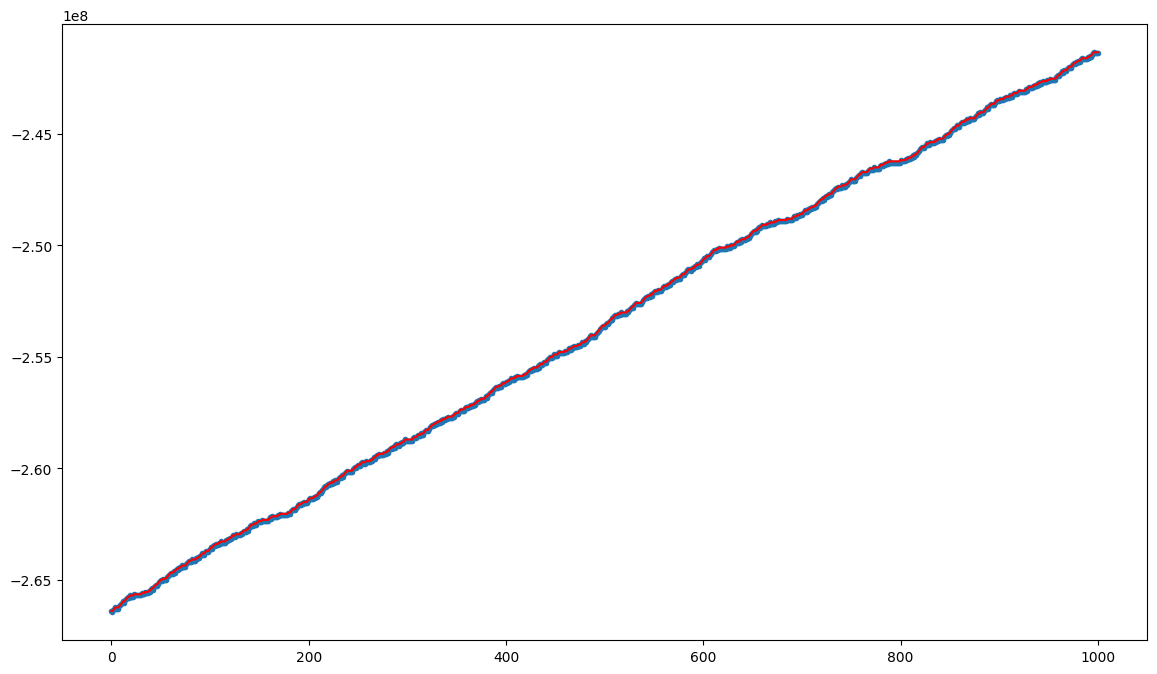

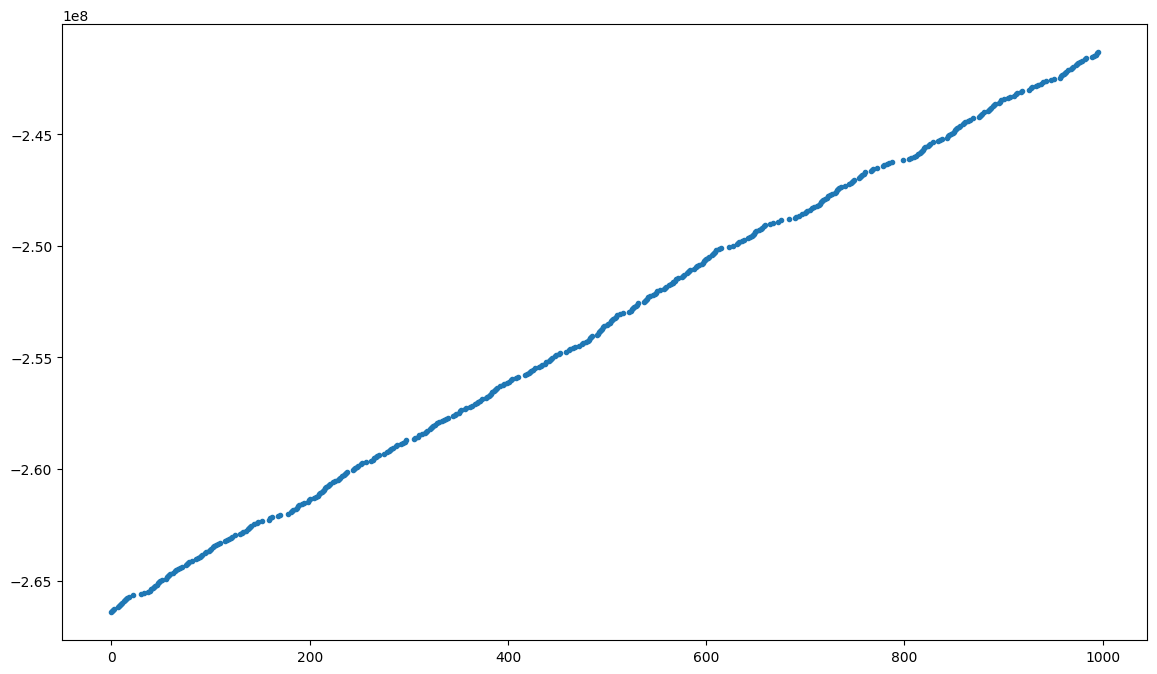

In [103]:
solution = rng.random(NUM_SETS) < 0.5
# to ensure we start with a valid solution(edge case for the first instances)
# in this way we escape a potential basin of attractions of invalid solutions
while not solution[0]:
    solution = rng.random(NUM_SETS) < 0.5


solution_fitness = ic(fitness(solution))
history=[solution_fitness[1]]
history_accepted =[(0,solution_fitness[1])]

# These values have been found by trial and error. A cross validation approach however might be better
# STARTING_VALUE_TEMP = 0.5
STARTING_VALUE_TEMP = 10
# INC_VALUE = STARTING_VALUE_TEMP
INC_VALUE = 1
# RESTART_THRESHOLD = 0.87
RESTART_THRESHOLD = 0.992


temperature = STARTING_VALUE_TEMP

best_sol_so_far = solution
fitness_best_sol_so_far = fitness(best_sol_so_far)
restart_counter = 0 
sim_ann_counter=0

# tweak=multiple_mutation_tweak
# tweak = probabilistic_tweak

ic.disable()
for steps in tqdm(range(N_STEPS)):
    new_solution = tweak(solution)
    ic(solution)
    ic(new_solution)
    f_newsol = fitness(new_solution)
    history.append(f_newsol[1])
    if  f_newsol[0] and f_newsol>solution_fitness or (  f_newsol[0] and simulated_annealing(solution_fitness[1],f_newsol[1],temperature)) :
        # Saving the best solution so far
        if f_newsol > fitness_best_sol_so_far:
            best_sol_so_far = new_solution
            fitness_best_sol_so_far = fitness(best_sol_so_far)

        solution=new_solution
        solution_fitness =  fitness(solution)

        # if a new solution has been accepted, we restart the temperature
        temperature = STARTING_VALUE_TEMP

        # ic.enable()
        # If the ratio between the new solution and the best solution so far is less than RESTART_THRESHOLD, then I restart from the best solution
        if (solution_fitness[1] != 0 and fitness_best_sol_so_far[1]/solution_fitness[1]) < RESTART_THRESHOLD:
            ic(f'Restarted!')
            restart_counter+=1
            solution = best_sol_so_far
            solution_fitness=fitness(solution)

        # ic.disable()
        history_accepted.append((steps,solution_fitness[1]))
        ic(fitness(new_solution))
    else:
        temperature+= INC_VALUE
ic.enable()

ic(sim_ann_counter)
ic(restart_counter)

ic(fitness(solution))
ic(fitness(best_sol_so_far))

ic(history.index(fitness(solution)[1]))
ic(history.index(fitness(best_sol_so_far)[1]))

scatter_plot(range(len(history)),history,[max(history[: i + 1]) for i in range(len(history))])
scatter_plot([elem[0] for elem in history_accepted], [elem[1] for elem in history_accepted])
